# Saliency Tuning

In this notebook, we attempt to refine the saliency maps generated by the WideResnet22 model which achieved 95% accuracy on the EuroSat dataset, and was trained in `EuroSat-SaliencyComparison.ipynb`. This is necessary to explore the limitations and capabilities of these maps.

For example: what is the best way to scale these maps to work at such a fine resolution? EuroSat is 10m/pixel, Urban 3D is 50cm/pixel. That's a 20x difference in 1D, but that's gigantic.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import fastai
from fastai.vision import *
import torch
from scipy.ndimage.filters import gaussian_filter as gaussian_filter

# Image Loading Utilities

Here we create some variables that make loading data very clear and simple.
Categories are mapped to indices located in the file `cat2idx.txt`. The images from EuroSat are loaded in randomly.

In [2]:
datadir='../EuroSat/'
categories = []
cat2idx = {}
with open("cat2idx.txt", "r") as f:
    for line in f:
        cat, idx = line.strip().split(":")
        categories.append(cat)
        cat2idx[cat] = int(idx)
        print(datadir+cat, "exists:", os.path.isdir(datadir+cat))
        
fnames = []
labels = []
for cat in categories:
    for name in os.listdir(datadir+cat):
        fnames.append(name)
        labels.append(cat2idx[cat])
labels = np.array(labels)

def load_img(index):
    """Loads an image into memory based upon the index, by piecing together pathname
    from global variables (datadir, categories, labels, fnames)"""
    path2img = os.path.join(datadir, categories[labels[index]], fnames[index])
    # CV2 reads in images BGR, we want RGB
    bgr = cv2.imread(path2img, cv2.IMREAD_COLOR)
    return np.dstack((bgr[...,-1], bgr[...,1], bgr[...,0])) / 255.0

../EuroSat/Residential exists: True
../EuroSat/Pasture exists: True
../EuroSat/Industrial exists: True
../EuroSat/HerbaceousVegetation exists: True
../EuroSat/PermanentCrop exists: True
../EuroSat/SeaLake exists: True
../EuroSat/River exists: True
../EuroSat/AnnualCrop exists: True
../EuroSat/Forest exists: True
../EuroSat/Highway exists: True


### Load in WideResnet22

#### Quick Hack
Apparently fastai's model class is _super_ tightly linked to its dataset class `DataBunch`. So close, that both objects need to be saved, in order for model inference to work properly - I have no idea why this is. But, I managed to get around this by just restoring the `CLASS_ORDERING` list which allows us to recover the `DataBunch` object even though I forgot to save it.

In [3]:
CLASS_ORDERING = [
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'
]

In [4]:
tfms = get_transforms(max_warp=0.0) # Applies fast.ai's default transforms
data = (ImageItemList.from_folder(datadir, recurse=True)
        .random_split_by_pct() # Train/Validation is 0.8/0.2 % of dataset
        .label_from_folder()
        .transform(tfms)
        .databunch() # Make into Fast.ai's dataset object
        .normalize([torch.tensor(0.0), torch.tensor(255.0)]) # Set range 0-1
       )
data.classes = CLASS_ORDERING
wrn = Learner(data, models.wrn_22(), metrics=accuracy)

In [5]:
wrn.load("wrn22-95")

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (21600 items)
[Category Residential, Category Residential, Category Residential, Category Residential, Category Residential]...
Path: ../EuroSat
x: ImageItemList (21600 items)
[Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64)]...
Path: ../EuroSat;

Valid: LabelList
y: CategoryList (5400 items)
[Category River, Category Highway, Category SeaLake, Category Pasture, Category Residential]...
Path: ../EuroSat
x: ImageItemList (5400 items)
[Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64)]...
Path: ../EuroSat;

Test: None, model=WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

#### Saliency Map Utilities

In [6]:
def make_torch(img):
    if len(img.shape) == 4:
        img = np.transpose(img, (0, 3, 1, 2))
    elif len(img.shape) == 3:
        img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
    else:
        raise ValueError("img needs to be rank 3 or rank 4 tensor")
    return torch.Tensor(img)

In [20]:
def make_sal(model, tensor, truth, loss):
    tensor = torch.autograd.Variable(tensor, requires_grad=True)
    out = model(tensor.cuda())
    # It took forever to figure out that .long() was required
    L = loss(out, truth.long().cuda())
    L.backward()
    return np.abs(tensor.grad.data.detach().cpu().numpy()).max(axis=1).squeeze()

#### Reviewing WideResnet's Performance

Seems to nail it!

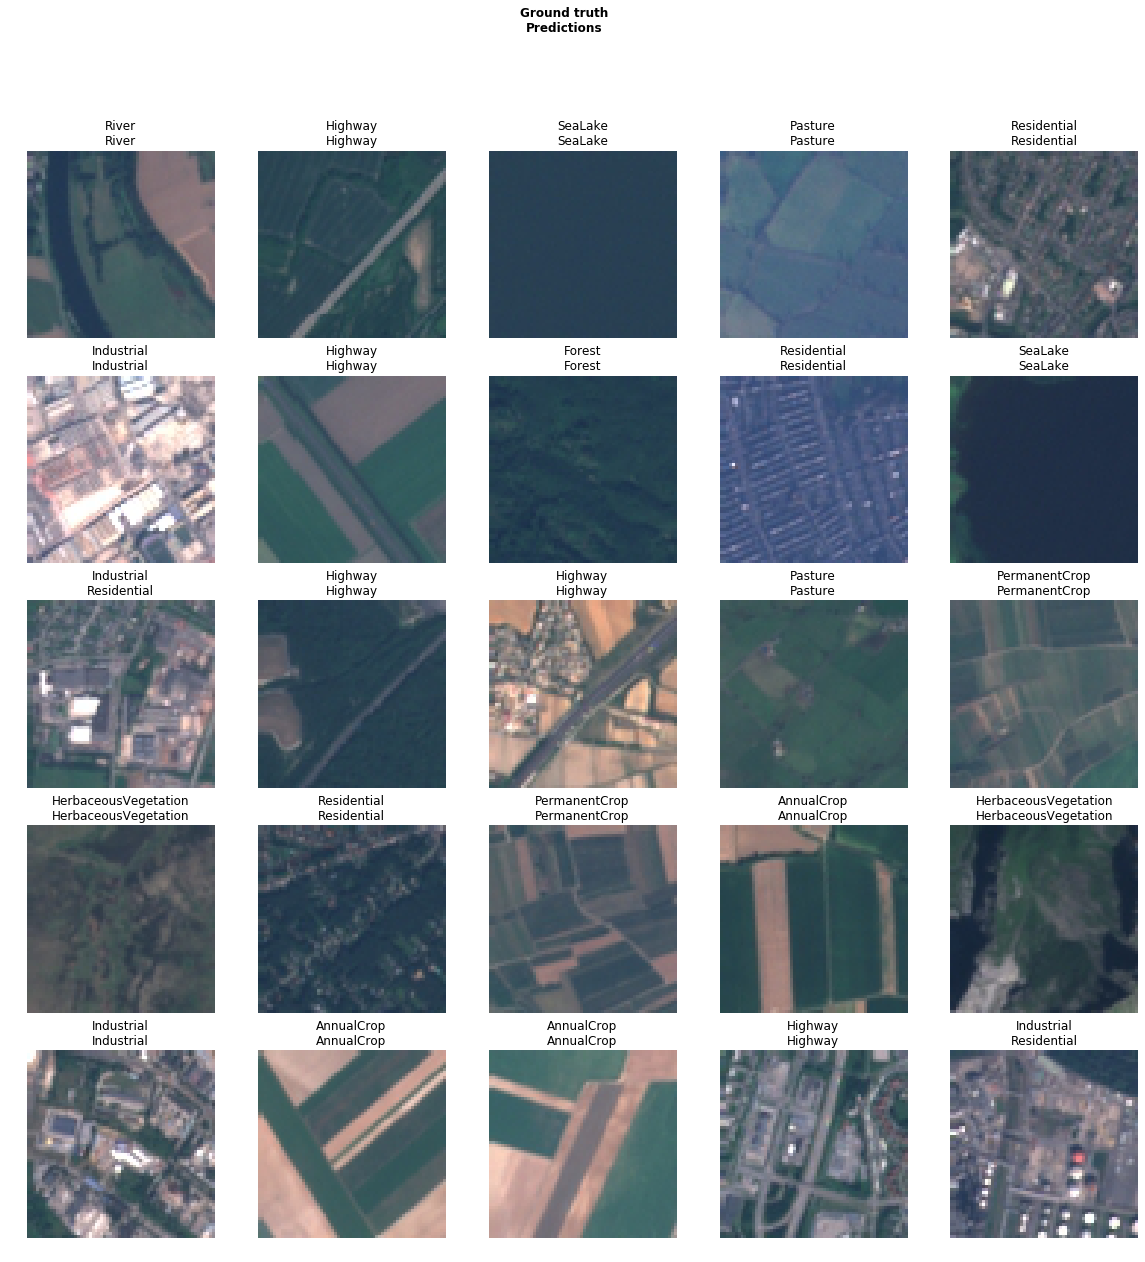

In [8]:
wrn.show_results()

# Visualizing its saliency maps

The only difference is that here, we remove edge artifacts from the saliency maps, and then resize by a factor of 20x in each dimension.

In [9]:
def clean_up(img, border=5):
    """Replaces img border with reflected border"""
    cropped = img[border:-border, border:-border]
    return cv2.copyMakeBorder(cropped, border, border, border, border, cv2.BORDER_REFLECT)

Because saliency maps require a loss value to be calculated, we can pretend

Truth is: Pasture


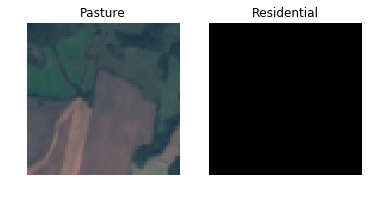

In [10]:
idx = np.random.choice(len(labels))
img = load_img(idx)
q = normalize(make_torch(load_img(0)), torch.Tensor([0]), torch.Tensor([255.0]))
fig, ax = plt.subplots(ncols=2)
for x in ax: x.axis("off")
    
with torch.no_grad():
    out = wrn.model(make_torch(img / 255.0).cuda())
    ax[0].set_title(f"{CLASS_ORDERING[out.squeeze().argmax()]}")
    out = wrn.model(q.cuda())
    ax[1].set_title(f"{CLASS_ORDERING[out.squeeze().argmax()]}")
    print(f"Truth is: {categories[labels[idx]]}")
ax[0].imshow(img)
ax[1].imshow(np.transpose(q.numpy().squeeze(), (1,2,0)))

tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -2.6076, -10.6140,  -3.4675,  -4.5425,
          -8.2495,  -2.5058, -12.0125]], device='cuda:0')
tensor([[ -4.6387,   5.7064,  -3.4584,  -

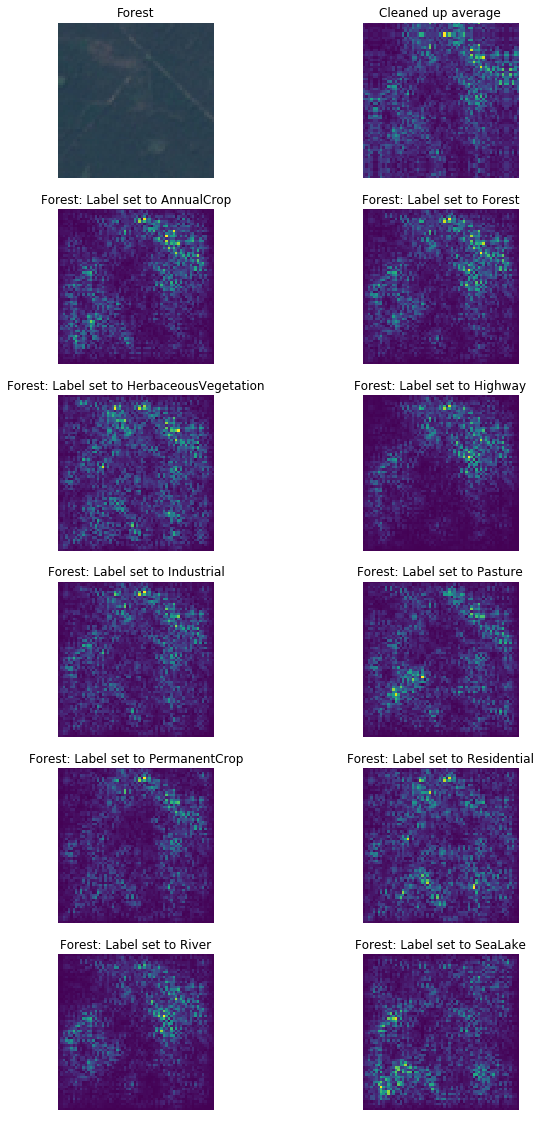

In [11]:
def plot_tuning(idx):
    fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(10,20))
    ax[0,0].axis("off")
    ax[0,0].imshow(load_img(idx))
    ax[0,0].set_title(f"{categories[labels[idx]]}")
    # fig.delaxes(ax[0,1])
    avgd = np.zeros((64,64))
    for i, x in enumerate(ax[1:].flatten()):
        input_tensor = make_torch(load_img(idx) / 255.0).cuda()
        sal = make_sal(wrn.model, input_tensor, torch.Tensor([i]).cuda(), wrn.loss_func.func)
        if i!=9:
            avgd = avgd + sal / 9.0
        x.imshow(sal)
        x.axis("off")
        with torch.no_grad():
            out = wrn.model(input_tensor)
            selection = out.squeeze().argmax()
            print(out)
            x.set_title(f"{CLASS_ORDERING[selection]}: Label set to {CLASS_ORDERING[i]}")
    ax[0,1].imshow(clean_up(avgd))
    ax[0,1].axis("off")
    ax[0,1].set_title("Cleaned up average")

idx = np.random.choice(len(labels))
plot_tuning(idx)

6.6050634 137.46829


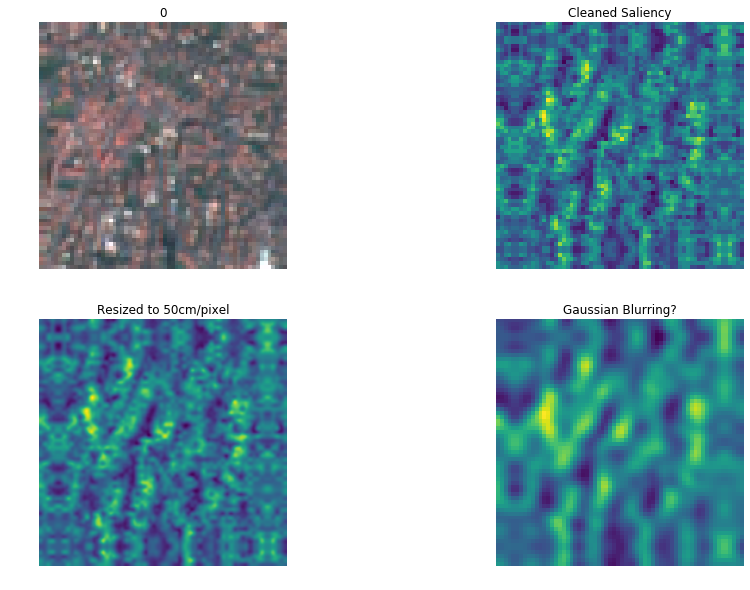

In [12]:
sal = clean_up(make_sal(wrn.model, make_torch(load_img(0)),
                        torch.Tensor([1]).cuda(),
                        wrn.loss_func.func))
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=2)
for x in axes.flatten():
    x.axis("off")
left,right = axes[0]
left.imshow(load_img(0))
left.set_title(labels[0])
right.imshow(sal)
right.set_title("Cleaned Saliency")
ll, lr = axes[1]
ll.imshow(cv2.resize(sal, (20*64, 20*64), interpolation=cv2.INTER_CUBIC))
ll.set_title("Resized to 50cm/pixel")
lr.imshow(gaussian_filter(sal, 1.5))
lr.set_title("Gaussian Blurring?")
print(sal.min(), sal.max())

# Creating Saliency Maps from Urban 3D

2 Datasets finally making contact.

In [13]:
import georaster
import gdal

def load_tiff(src, tiff=False):
    has_alpha = 0
    src_ds = gdal.Open(src, gdal.GA_ReadOnly)
    if tiff:
        return src_ds
    last_channel = src_ds.RasterCount + (1 if not has_alpha else 0)
    arr = [src_ds.GetRasterBand(idx).ReadAsArray() for idx in range(1, last_channel)]
    return np.dstack(arr)


traindir = '../Train/Inputs/'
truthdir = '../Train/GT/'
# Gets RGB names
names = list([name for name in os.listdir(traindir) if name[-7:] == 'RGB.tif' ])

In [14]:
maxs = [0, 0, 0]
mins = [1e3, 1e3, 1e3]
min_fs = [0]*3
max_fs = [0]*3
for idx in range(len(names)):
    dsm = load_tiff(traindir+names[idx].replace("RGB","DSM"))
    dtm = load_tiff(traindir+names[idx].replace("RGB","DTM"))
    dem = dsm - dtm
    for i,arr in enumerate([dsm, dtm, dem]):
        if maxs[i] < arr.max():
            maxs[i] = arr.max()
            max_fs[i] = names[idx]
        if mins[i] > arr.min():
            mins[i] = arr.min()
            min_fs[i] = names[idx]
for name, big, small, max_f, min_f in zip(["DSM", "DTM", "DEM"], maxs, mins, max_fs, min_fs):
    print(f"{name} min:{small:<6.2f}\tmax:{big:<6.2f}\t{min_f}\t{max_f}")

DSM min:-32767.00	max:160.12	TAM_Tile_011_RGB.tif	JAX_Tile_041_RGB.tif
DTM min:-32767.00	max:8.28  	TAM_Tile_011_RGB.tif	JAX_Tile_010_RGB.tif
DEM min:-11.26	max:184.26	JAX_Tile_041_RGB.tif	JAX_Tile_041_RGB.tif


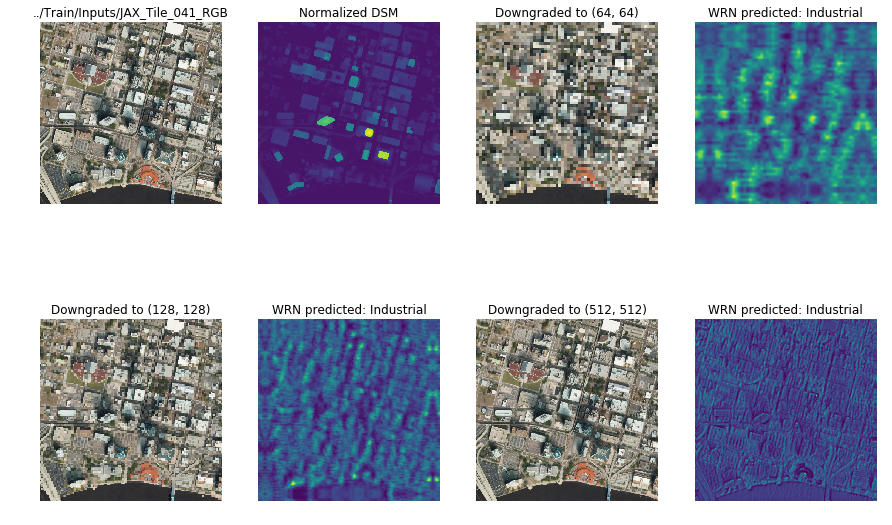

In [15]:
curr_name = traindir+min_fs[-1]
img = load_tiff(curr_name)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
# Remove ticks & spines
for x in ax.flatten():
    x.axis("off")
left, right = ax[0,:2]
# Plot image & depth mapping as first 2 plots
left.imshow(img)
left.set_title(curr_name[:-4])
dsm = load_tiff(curr_name.replace("RGB","DSM"))
dtm = load_tiff(curr_name.replace("RGB","DTM"))
dem = dsm - dtm
right.imshow(dem.squeeze())
right.set_title("Normalized DSM")
del(dsm, dtm, dem)
sizes = [(64, 64), (128, 128), (512, 512)]
for i, x in enumerate(ax.flatten()[2:]):
    if i % 2 == 0:
        x.set_title(f"Downgraded to {sizes[i//2]}")
        x.imshow(cv2.resize(img, sizes[i//2]))
    else:
        sal = make_sal(wrn.model, make_torch(cv2.resize(img, sizes[i//2])/255.0), torch.Tensor([1]).cuda(), wrn.loss_func.func)
        with torch.no_grad():
            wrn.model.zero_grad()
            out = wrn.model(make_torch(cv2.resize(img, sizes[i//2])/255.0).cuda())
        x.set_title(f"WRN predicted: {CLASS_ORDERING[out.squeeze().argmax()]}")
        x.imshow(cv2.resize(clean_up(sal), (2048, 2048)))

In [33]:
def get_saliency_big(model, input_tensor, truth, loss, verbose=False):
    """Takes in input tensor of size [4, 2048, 2048]"""
    step = 512
    preds = []
    for x in range(0, 2048, step):
        for y in range(0, 2048, step):
            preds.append(make_sal(model, input_tensor[:, :, x:x+step, y:y+step],
                                     truth, loss))
    num_steps = 2048 // step
    rows = []
    # bind matrices into rows
    for i in range(0,len(preds),num_steps):
        row = np.concatenate(preds[i:i+num_steps], axis=1)
        rows.append(row)
    # bind rows into matrix
    sal = np.concatenate(rows, axis=0)
#     g_range = sal.max() - sal.min()
#     sal /= g_range
    return sal

In [34]:
sal = get_saliency_big(wrn.model, make_torch(img), torch.Tensor([1]), wrn.loss_func.func)

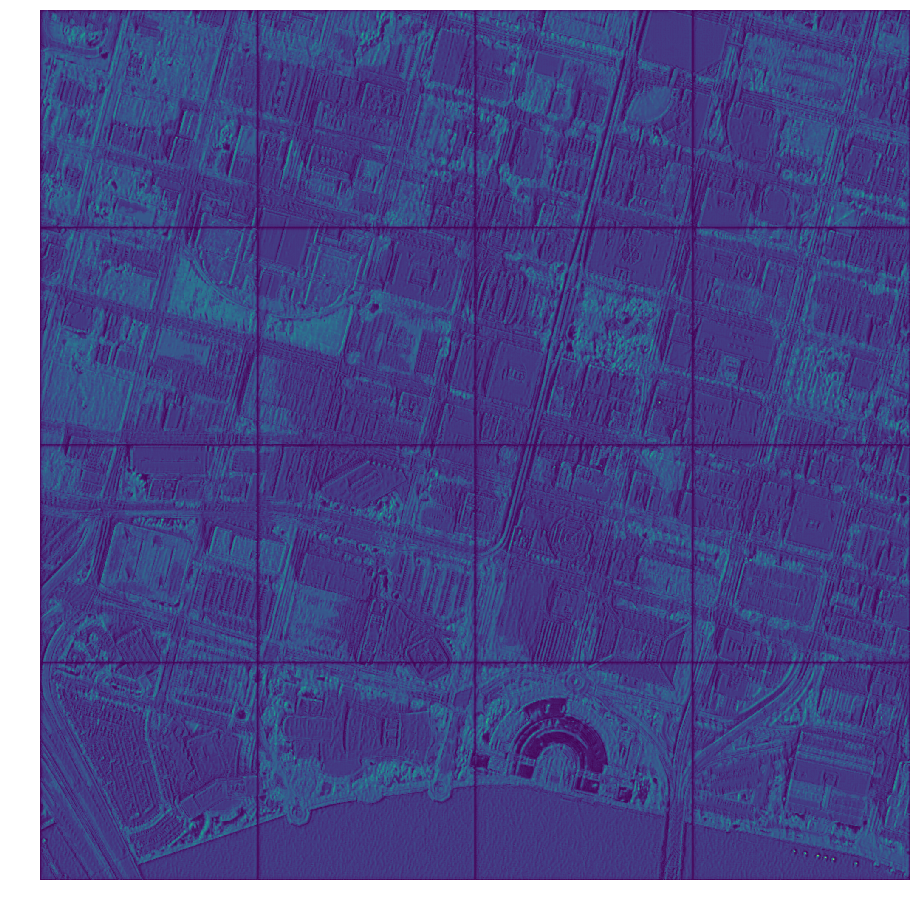

In [36]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(sal)